# Task 4: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Tasks
You will use word vectors pre-computed on a large dataset.
1. **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
2. **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

3. **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
4. **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## App1

In [23]:
import gensim.downloader as api
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random
import string
from sklearn.preprocessing import normalize
from scipy.linalg import orthogonal_procrustes


In [ ]:
w2v = api.load("word2vec-google-news-300")
ft = api.load("fasttext-wiki-news-subwords-300")


### 1

In [8]:
from gensim.test.utils import datapath
questions_path = datapath("questions-words.txt")

def analogy_score(model):
    accuracy = model.evaluate_word_analogies(questions_path)
    correct = sum(len(section['correct']) for section in accuracy[1])
    total = correct + sum(len(section['incorrect']) for section in accuracy[1])
    return correct / total if total > 0 else 0

print("Analogy accuracy:")
print("Word2Vec:", round(analogy_score(w2v), 3))
print("FastText:", round(analogy_score(ft), 3))


Analogy accuracy:
Word2Vec: 0.74
FastText: 0.883


### 2

In [24]:
dict_file = "input/en-pl.txt"

def load_dictionary(file_path):
    dictionary = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split()
                if len(parts) == 2:
                    # dictionary[parts[0]] = parts[1]
                    dictionary.append((parts[0], parts[1]))

    return dictionary

In [34]:
# sample bilingual dictionary
dictionary = load_dictionary(dict_file)
print(f"Loaded {len(dictionary)} translations")

# filter only valid pairs
en_words = []
pl_words = []

for en, pl in dictionary:
    if en in ft and pl in ft:
        en_words.append(ft[en])
        pl_words.append(ft[pl])

X = np.stack(en_words)
Y = np.stack(pl_words)

# Procrustes: find orthonormal matrix W minimizing ||XW - Y||^2
W, _ = orthogonal_procrustes(X, Y)

print("Orthogonal Procustres ", W.shape)
print(W)

# apply transformation
x_proj = X @ W


Loaded 73883 translations
Orthogonal Procustres  (300, 300)
[[ 9.9862933e-01  4.2824065e-03 -4.3749153e-03 ...  5.0295191e-03
   1.5163278e-03  1.4829134e-03]
 [-4.5438753e-03  9.9886358e-01 -1.0625347e-03 ...  8.3437189e-04
  -7.9497905e-04 -6.1761460e-04]
 [ 2.1534665e-03  5.4924935e-04  9.9725056e-01 ...  6.0408171e-03
   1.1076905e-03 -1.0125282e-03]
 ...
 [-5.6084422e-03 -9.5557718e-04 -6.0600992e-03 ...  9.9746823e-01
   1.7199934e-03 -2.7558638e-03]
 [-1.3721841e-03  8.8236219e-04 -3.0783693e-05 ... -3.6231899e-03
   9.9833477e-01 -5.2582705e-04]
 [-1.0308872e-03  7.1939739e-04  1.8036552e-03 ...  3.2110903e-03
   5.2163756e-04  9.9902517e-01]]


### 3

In [16]:
capitals_file = "input/capitals.txt"
def load_capitals(file_path):
    capitals = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                parts = line.strip().split()
                if len(parts) == 2:
                    capitals.append((parts[0], parts[1]))
    return capitals

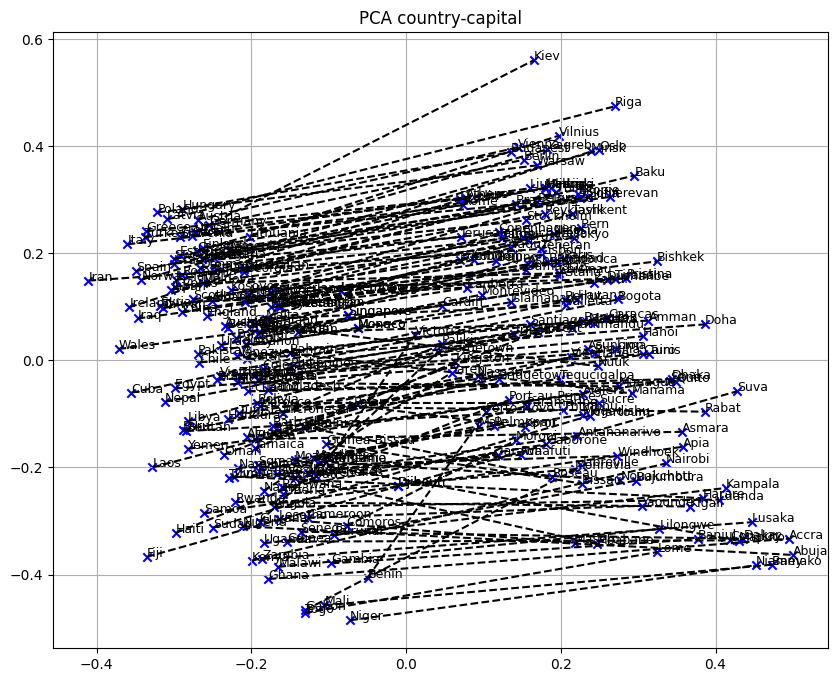

In [21]:
country_capital_pairs = load_capitals(capitals_file)

vectors = []
labels = []
connections = []

for country, capital in country_capital_pairs:
    if country in ft and capital in ft:
        vectors.append(ft[country])
        vectors.append(ft[capital])
        labels.extend([country, capital])
        connections.append((len(vectors)-2, len(vectors)-1))

# PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# plot
plt.figure(figsize=(10, 8))
for i, label in enumerate(labels):
    plt.scatter(*reduced[i], marker='x', color='blue')
    plt.text(*reduced[i], label, fontsize=9)
for i, j in connections:
    plt.plot([reduced[i,0], reduced[j,0]], [reduced[i,1], reduced[j,1]], 'k--')
plt.title("PCA country-capital")
plt.grid()
plt.show()


### 4

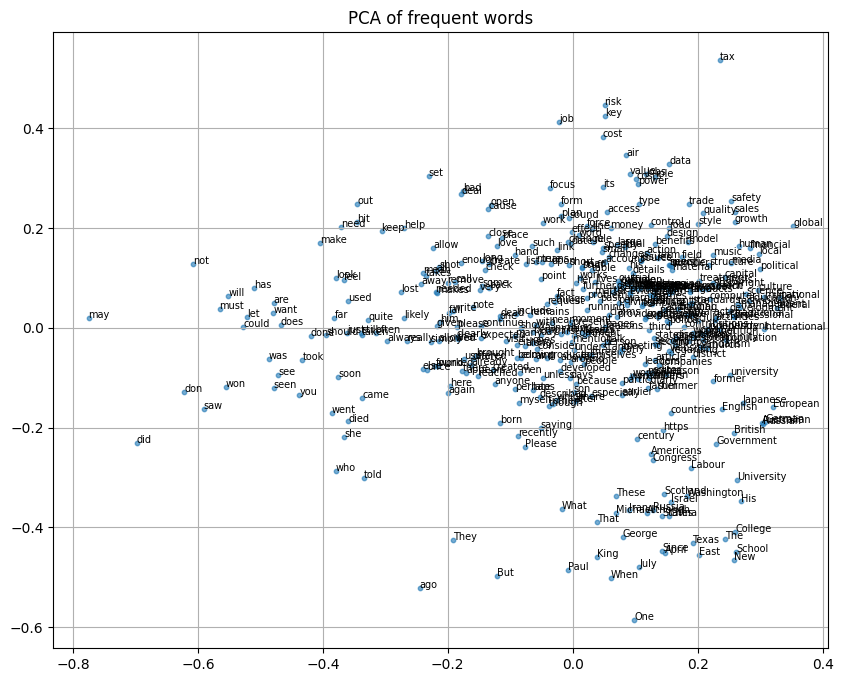

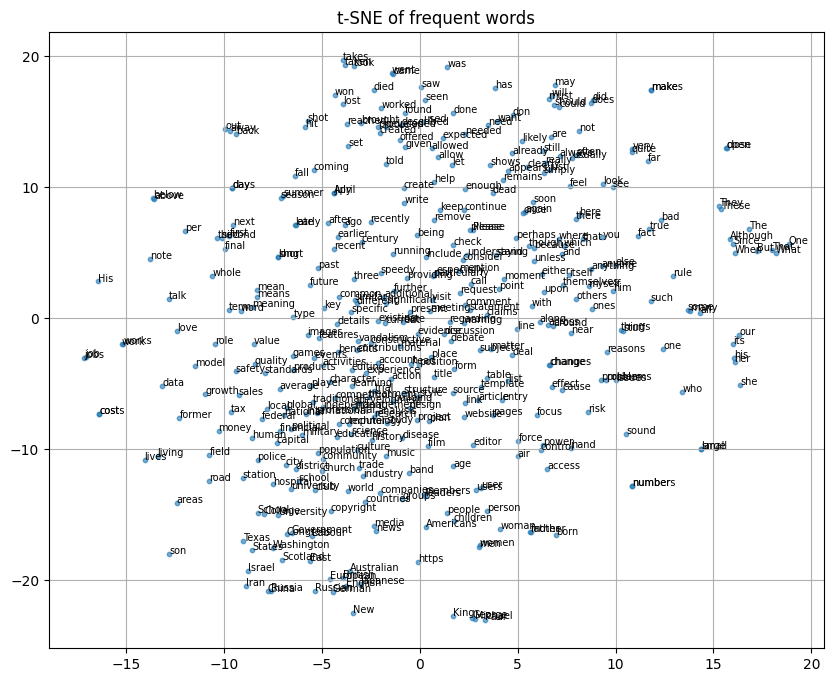

In [20]:
def is_valid(word):
    return word.isalpha() and len(word) >= 3

words = [w for w in ft.index_to_key if is_valid(w)]
top_words = words[:1000]  # sample larger pool
sample_words = random.sample(top_words, 400)
vectors = [ft[w] for w in sample_words]

# PCA
reduced_pca = PCA(n_components=2).fit_transform(np.array(vectors))

plt.figure(figsize=(10, 8))
plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], s=10, alpha=0.6)
for i, word in enumerate(sample_words):
    plt.text(reduced_pca[i, 0], reduced_pca[i, 1], word, fontsize=7)
plt.title("PCA of frequent words")
plt.grid()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, init='pca', learning_rate=200, random_state=42)
reduced_tsne = tsne.fit_transform(np.array(vectors))


plt.figure(figsize=(10, 8))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], s=10, alpha=0.6)
for i, word in enumerate(sample_words):
    plt.text(reduced_tsne[i, 0], reduced_tsne[i, 1], word, fontsize=7)
plt.title("t-SNE of frequent words")
plt.grid()
plt.show()


____

## App2

In [7]:
# Common imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import orthogonal_procrustes
import gensim.downloader as api
from nltk.corpus import stopwords
import requests
from io import StringIO

# Download stopwords
import nltk
nltk.download('stopwords')

# Task 4.1: Analogy Accuracy
def load_analogy_dataset(url):
    response = requests.get(url)
    return [line.split() for line in response.text.splitlines() if not line.startswith(':')]

analogy_url = "https://raw.githubusercontent.com/nicholas-leonard/word2vec/master/questions-words.txt"
analogies = load_analogy_dataset(analogy_url)

def evaluate_analogies(model, analogies):
    correct = 0
    total = 0
    for row in analogies:
        if all(word in model for word in row):
            a, b, c, d = row
            try:
                predicted = model.most_similar(positive=[b, c], negative=[a], topn=1)[0][0]
                correct += (predicted == d)
                total += 1
            except KeyError:
                continue
    return correct / total if total > 0 else 0

# Load models
ft = api.load('fasttext-wiki-news-subwords-300')
w2v = api.load('word2vec-google-news-300')

# Compare performance
ft_score = evaluate_analogies(ft, analogies)
w2v_score = evaluate_analogies(w2v, analogies)
print(f"FastText Accuracy: {ft_score:.2%}")
print(f"Word2Vec Accuracy: {w2v_score:.2%}")

# Task 4.2: Orthonormal Mapping
def load_bilingual_dict(url):
    response = requests.get(url)
    return [line.split() for line in response.text.splitlines() if len(line.split('\t')) == 2]

dict_url = "https://dl.fbaipublicfiles.com/arrival/dictionaries/en-pl.txt"
bilingual_pairs = load_bilingual_dict(dict_url)

def procrustes_mapping(source_model, target_model, pairs):
    X, Y = [], []
    for en, pl in pairs:
        if en in source_model and pl in target_model:
            X.append(source_model[en])
            Y.append(target_model[pl])
    X = np.array(X)
    Y = np.array(Y)
    W, _ = orthogonal_procrustes(X, Y)
    return W

# Load Polish FastText model
pl_model = api.load('fasttext-wiki-news-subwords-300')  # Replace with actual Polish model

# Compute mapping matrix
W = procrustes_mapping(ft, pl_model, bilingual_pairs[:1000])

# Task 4.3: Country-Capital Visualization
countries = ['France', 'Germany', 'Poland', 'Italy', 'Spain']
capitals = ['Paris', 'Berlin', 'Warsaw', 'Rome', 'Madrid']

def get_vectors(words, model):
    return [model[word] for word in words if word in model]

country_vecs = get_vectors(countries, ft)
capital_vecs = get_vectors(capitals, ft)

pca = PCA(n_components=2)
combined = pca.fit_transform(country_vecs + capital_vecs)

plt.figure(figsize=(10, 6))
for i in range(len(countries)):
    plt.plot([combined[i][0], combined[i+len(countries)][0]],
             [combined[i][1], combined[i+len(countries)][1]], 'k--')
    plt.scatter(combined[i][0], combined[i][1], c='b', label='Country' if i==0 else "")
    plt.scatter(combined[i+len(countries)][0], combined[i+len(countries)][1], c='r', label='Capital' if i==0 else "")
plt.legend()
plt.title('Country-Capital Relationships')
plt.show()

# Task 4.4: Frequent Words Visualization
def get_frequent_words(model, n=400):
    words = [word for word in model.index_to_key if len(word) > 2 and word.isalpha()]
    words = [word for word in words if word not in stopwords.words('english')]
    return words[:n]

words = get_frequent_words(ft, 400)
vectors = ft[words]

# PCA Visualization
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(vectors)

plt.figure(figsize=(12, 8))
plt.scatter(pca_emb[:, 0], pca_emb[:, 1], alpha=0.5)
for i, word in enumerate(words[:50]):
    plt.annotate(word, (pca_emb[i, 0], pca_emb[i, 1]), fontsize=8)
plt.title('PCA Visualization of Frequent Words')
plt.show()

# t-SNE Visualization with optimized parameters
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000, learning_rate=200, init='pca')
tsne_emb = tsne.fit_transform(vectors)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], alpha=0.5)
for i, word in enumerate(words[:50]):
    plt.annotate(word, (tsne_emb[i, 0], tsne_emb[i, 1]), fontsize=8)
plt.title('t-SNE Visualization of Frequent Words')
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: 